In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import math
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.subplots as sub
import dash
from dash import dcc, html, Output, Input, State
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, confusion_matrix, top_k_accuracy_score
from sklearn.model_selection import StratifiedKFold
import optuna
from optuna.trial import TrialState
#from optuna.integration import PyTorchIgnitePruningHandler

from functools import partial
import random
import os
import itertools
from PIL import Image
from tqdm.auto import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torchvision
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset, Subset
from torchvision.models import vgg16_bn, resnet50, resnet18, efficientnet_b0, densenet121, ResNet50_Weights, ResNet18_Weights, VGG16_BN_Weights, DenseNet121_Weights, EfficientNet_B0_Weights
from torchvision.utils import make_grid, draw_bounding_boxes, draw_segmentation_masks, draw_keypoints
from torchvision import datasets
from torchvision.transforms import ToTensor, v2, ToPILImage
from torchvision.io import decode_image

# from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
# from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
# from ignite.handlers import ModelCheckpoint, EarlyStopping

from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
from torch.amp import GradScaler, autocast

from transformers import ViTForImageClassification, ViTImageProcessor, AutoModelForImageClassification, AutoImageProcessor, Trainer, TrainingArguments
from huggingface_hub import snapshot_download, hf_hub_download
import socket
import json
import sys
import io
import base64

In [2]:
# # for python
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..', 'src')))
# import data_utils


In [3]:
# # for notebook
# sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
# import helper_module


In [4]:
os.getcwd()

'C:\\Users\\chocp\\MADS\\699\\apps'

In [5]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

In [6]:
from data_utils import FGVCAircraftDataset, get_datasets, get_loaders, get_raw

In [7]:
import aircraft_utils, models

In [8]:
ROOT = get_raw()

In [9]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

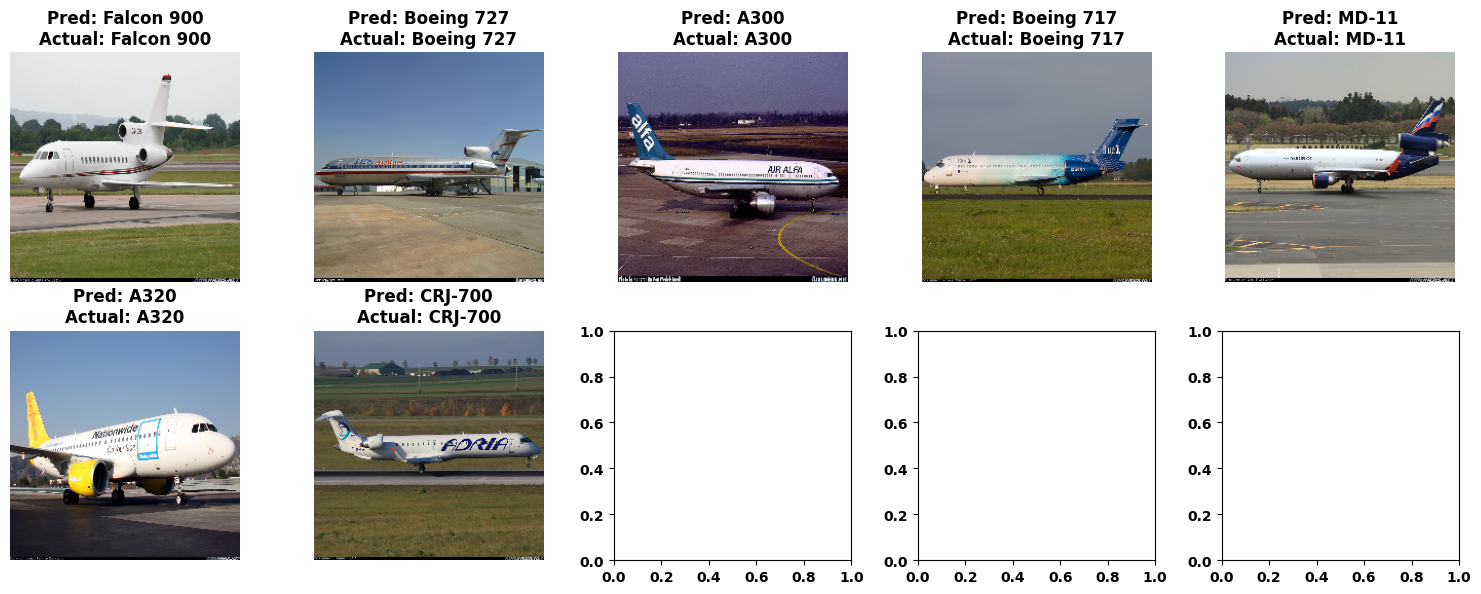

Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

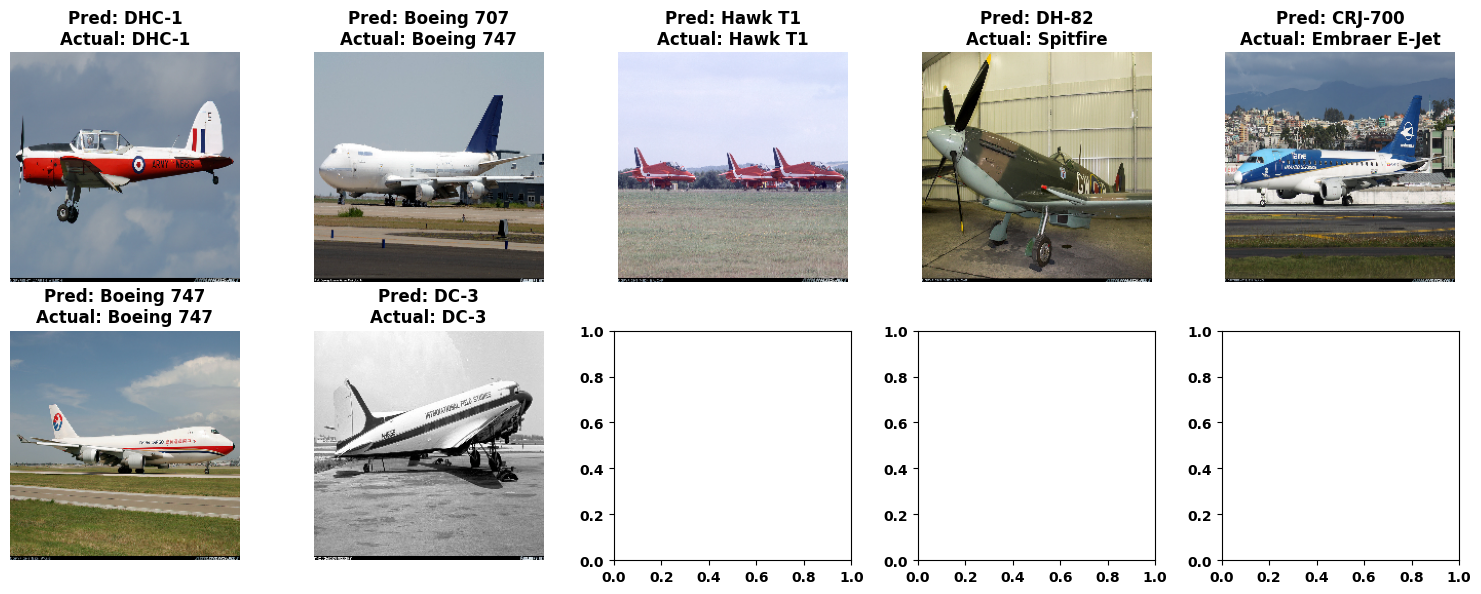

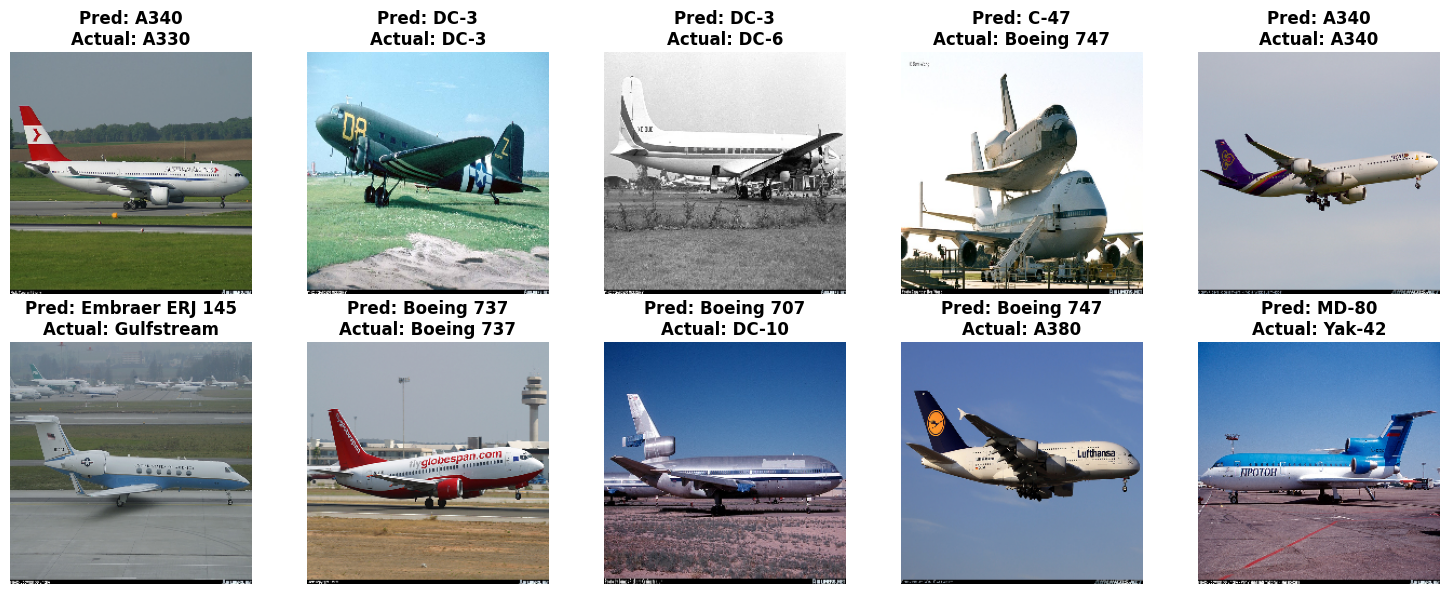

In [10]:
# initialize dash app.
app = dash.Dash(__name__)

LEVELS = ['manufacturer', 'family', 'variant']
loaded_datasets = {}

app.layout = html.Div([
    html.H2("FGVC Aircraft Dashboard"), # dashboard title
    dcc.RadioItems(
        id='mode-selector',
        options=[
            {'label': 'Dataset Viewer', 'value': 'viewer'},
            {'label': 'Pre-trained Model', 'value': 'pretrain'},
            {'label': 'Run Training', 'value': 'train'},
            
        ],
        value='viewer',
        inline=True
    ),
    html.Div(id='common-controls', children=[
        html.Label("Select Level:"),
        dcc.Dropdown(id='level-dropdown', options=[{'label': lvl.title(), 'value': lvl} for lvl in LEVELS])
    ]),
    html.Div(id='train-controls', style={'display': 'none'}, children=[
        html.Label("Image Size:"),
        dcc.Input(id='img-size', type='number', value=224),
        html.Label("Batch Size:"),
        dcc.Input(id='batch-size', type='number', value=16),
        html.Label("Select Training Level:"),
        dcc.Dropdown(id='train-level-dropdown', options=[{'label': lvl.title(), 'value': lvl} for lvl in LEVELS], value='manufacturer'),
        html.Label("Patience:"),
        dcc.Input(id='patience', type='number', value=2),
        html.Label("Number of Epochs:"),
        dcc.Input(id='num-epochs', type='number', value=5),
        html.Button('Start Training', id='train-button', n_clicks=0),
        html.Div(id='train-status', style={'marginTop': '10px', 'color': 'blue'})
    ]),
    html.Div(id='predict-controls', children=[
        html.Label("Number of Samples to Predict:"),
        dcc.Input(id='num-samples', type='number', min=1, max=50, value=10),
        # html.Br(),
        html.Label("Select Prediction Level:"),
        dcc.Dropdown(id='predict-level-dropdown', options=[{'label': lvl.title(), 'value': lvl} for lvl in LEVELS], value='manufacturer'),
        html.Button('Run Prediction', id='predict-button', n_clicks=0),
        #html.Div(id='prediction-output')
        
        dcc.Loading(
            id='loading-predict',
            type='circle',
            children=html.Div(id='prediction-output')
        )

    ]),
    html.Div(id='viewer-controls', style={'display': 'none'}, children=[
        html.P(f"Press Load Dataset button below or insert directory where you saved torchvision.datasets.FGVCAircraft() to."),
        dcc.Input(id='path-input', type='text', placeholder='Enter dataset root path', style={'width': '60%'}, value=str(ROOT)),
        html.Button('Load Dataset', id='load-button', n_clicks=0),
        html.Div(id='load-status', style={'marginTop': '10px', 'color': 'green'}),
        html.Br(),
        html.Label("Select Level:"),
        dcc.Dropdown(id='lvl-dropdown', options=[{'label': lvl.title(), 'value': lvl} for lvl in LEVELS], value='manufacturer'),
        html.Label("Select Class:"),
        dcc.Dropdown(id='class-dropdown'),
        html.Div(id='image-output', style={'display': 'flex', 'flexWrap': 'wrap'})
    ]),
    #dcc.Store(id='model-meta-store')
    dcc.Store(id='model-meta-store', data={})
])
@app.callback(
    Output('train-controls', 'style'),
    Output('predict-controls', 'style'),
    Output('viewer-controls', 'style'),
    Input('mode-selector', 'value')
)
def toggle_controls(mode):    
    styles = {
        'train': {'train': 'block', 'predict': 'block', 'viewer': 'none'},
        'pretrain': {'train': 'none', 'predict': 'block', 'viewer': 'none'},
        'viewer': {'train': 'none', 'predict': 'none', 'viewer': 'block'}
    }
    selected = styles.get(mode, {'train': 'none', 'predict': 'none', 'viewer': 'none'})

    return (
        {'display': 'block'} if mode == 'train' else {'display': 'none'},
        {'display': 'block'} if mode in ['train', 'pretrain'] else {'display': 'none'},
        {'display': 'block'} if mode == 'viewer' else {'display': 'none'}
    )
@app.callback(
    [Output('train-status', 'children'),
     Output('model-meta-store', 'data')],
    Input('train-button', 'n_clicks'),
    State('img-size', 'value'),
    State('batch-size', 'value'),
    State('train-level-dropdown', 'value'),
    State('patience', 'value'),
    State('num-epochs', 'value')
)
def run_training(n_clicks, img_size, batch_size, annot, patience, num_epochs):
    if n_clicks > 0:
        train_loader, val_loader, test_loader, num_classes, class_names = get_loaders(img_size=img_size, batch_size=batch_size, annot=annot)
        model = models.CAPResNet(num_classes, drop=0.3563).to(device)
        criterion = nn.CrossEntropyLoss(label_smoothing=0.046858)
        optimizer = optim.Adam(model.parameters(), lr=5.1872e-05, weight_decay=0.002925)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        scaler = GradScaler('cuda')
        best_val_loss = float('inf')
        epochs_without_improvement = 0
        model_path = os.path.join(os.pardir, "models", "best_model_dash.pth")
        for epoch in range(num_epochs):
            train_loss, train_acc, _, _ = aircraft_utils.train_one_epoch(model, train_loader, criterion, optimizer, 'cuda', scaler)
            val_loss, val_acc, _, _, _, _ = aircraft_utils.evaluate(model, val_loader, criterion, 'cuda')
            scheduler.step(val_loss)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0
                torch.save(model.state_dict(), model_path)
            else:
                epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                break
        return (
            f"Training for {num_epochs} epochs completed. Best model with {num_classes} classes at {annot} level saved as best_model_dash.pth with val loss {best_val_loss:.4f}",
            {'num_classes': num_classes, 'class_names': class_names}
        )
    return "", {}
@app.callback(
    Output('prediction-output', 'children'),
    Input('predict-button', 'n_clicks'),
    State('mode-selector', 'value'),
    State('predict-level-dropdown', 'value'),
    State('num-samples', 'value'),
    State('model-meta-store', 'data')
)
# def run_prediction(n_clicks, mode, level, num_samples, model_meta):
#     if n_clicks > 0 and level:
#         try:
#             if mode == 'pretrain':
#                 model_path = os.path.join(os.pardir, "models", f"best_model_{level}.pth")
#                 _, _, test_loader, num_classes, class_names = get_loaders(img_size=224, batch_size=16, annot=level)
#             else:
#                 num_classes = model_meta.get('num_classes')
#                 class_names = model_meta.get('class_names')
#                 if num_classes is None:
#                     raise ValueError("Model metadata missing. Please run training first.")
#                 model_path = os.path.join(os.pardir, "models", "best_model_dash.pth")
#             model = models.CAPResNet(num_classes, drop=0.3563).to(device)
#             model.load_state_dict(torch.load(model_path))
#             model.eval()
#             test_dataset = get_datasets(224, 16, level)[2]
#             buf = io.BytesIO()
#             aircraft_utils.visualize_predictions(model, test_dataset, num_samples=num_samples)
#             plt.savefig(buf, format='png')
#             plt.close()
#             buf.seek(0)
#             encoded = base64.b64encode(buf.read()).decode('utf-8')
#             img_src = f'data:image/png;base64,{encoded}'
#             return html.Img(src=img_src, style={'width': '100%', 'marginTop': '20px'})
#         except Exception as e:
#             return html.Div(f"Error running prediction: {str(e)}", style={'color': 'red'})
#     return ""


def run_prediction(n_clicks, mode, level, num_samples, model_meta):
    if n_clicks > 0 and level:
        try:
            if mode == 'pretrain':
                model_path = os.path.join(os.pardir, "models", f"best_model_{level}.pth")
                _, _, test_loader, num_classes, class_names = get_loaders(img_size=224, batch_size=16, annot=level)
            else:
                if not model_meta or 'num_classes' not in model_meta or 'class_names' not in model_meta:
                    raise ValueError("Model metadata missing. Please run training or select a pre-trained model.")
                num_classes = model_meta['num_classes']
                class_names = model_meta['class_names']
                model_path = os.path.join(os.pardir, "models", "best_model_dash.pth")

            model = models.CAPResNet(num_classes, drop=0.3563).to(device)
            model.load_state_dict(torch.load(model_path))
            model.eval()

            test_dataset = get_datasets(224, 16, level)[2]
            buf = io.BytesIO()
            aircraft_utils.visualize_predictions(model, test_dataset, num_samples=num_samples)
            plt.savefig(buf, format='png')
            plt.close()
            buf.seek(0)
            encoded = base64.b64encode(buf.read()).decode('utf-8')
            img_src = f'data:image/png;base64,{encoded}'
            return html.Img(src=img_src, style={'width': '100%', 'marginTop': '20px'})
        except Exception as e:
            return html.Div(f"Error running prediction: {str(e)}", style={'color': 'red'})
    return ""

@app.callback(
    Output('load-status', 'children'),
    Output('level-dropdown', 'value'),
    Input('load-button', 'n_clicks'),
    State('path-input', 'value')
)
def load_dataset(n_clicks, path):
    if n_clicks > 0 and path:
        try:
            for level in LEVELS:
                loaded_datasets[level] = FGVCAircraftDataset(root=path, split='train', level=level, return_class=True)
            return f"Dataset loaded successfully from: {path}", 'manufacturer'
        except Exception as e:
            return f"Error loading dataset: {str(e)}", None
    return "", None
@app.callback(
    Output('class-dropdown', 'options'),
    Output('class-dropdown', 'value'),
    Input('level-dropdown', 'value')
)
def update_class_dropdown(level):
    if level and level in loaded_datasets:
        dataset = loaded_datasets[level]
        options = [{'label': cls, 'value': cls} for cls in dataset.classes]
        return options, options[0]['value'] if options else None
    return [], None
@app.callback(
    Output('image-output', 'children'),
    Input('level-dropdown', 'value'),
    Input('class-dropdown', 'value')
)
def display_images(level, selected_class):
    if level in loaded_datasets and selected_class:
        dataset = loaded_datasets[level]
        indices = [i for i, (_, cls) in enumerate(dataset.samples) if cls == selected_class]
        if not indices:
            return [html.Div("No images found for this class.", style={'color': 'red'})]

        selected_indices = random.sample(indices, min(5, len(indices)))
        images = []

        for idx in selected_indices:
            img, cls = dataset[idx]
            if isinstance(img, Image.Image):
                buffer = np.array(img)
            else:
                buffer = img.permute(1, 2, 0).numpy()
                buffer = (buffer * 255).astype(np.uint8)  # Convert to uint8 for display

            fig = px.imshow(buffer)
            fig.update_layout(coloraxis_showscale=False, margin=dict(l=0, r=0, t=0, b=0))
            images.append(html.Div(dcc.Graph(figure=fig), style={'margin': '10px'}))

        return images
    return []

def find_free_port():
    s = socket.socket()
    s.bind(('', 0))
    return s.getsockname()[1]

port = find_free_port()   

if __name__ == '__main__':
    app.run(debug=True, port=port)

In [26]:
ROOT

WindowsPath('C:/Users/chocp/Capstone/FGVCAircraft/fgvc-aircraft-2013b/data')

In [ ]:

def visualize_predictions_plotly(model, dataset, num_samples=5):
    model.eval()
    fig = sub.make_subplots(rows=1, cols=num_samples)
    for i in range(num_samples):
        img, label = dataset[i]
        with torch.no_grad():
            output = model(img.unsqueeze(0).to(device))
            probs = torch.nn.functional.softmax(output, dim=1)
            pred = torch.argmax(probs, dim=1).item()
            confidence = probs[0][pred].item()
        img_np = img.permute(1, 2, 0).cpu().numpy()
        fig.add_trace(
            go.Image(z=img_np),
            row=1, col=i+1
        )
        fig.update_xaxes(showticklabels=False, row=1, col=i+1)
        fig.update_yaxes(showticklabels=False, row=1, col=i+1)
        fig.layout.annotations[i].text = f"{class_names[pred]}<br>({confidence:.2%})"
    return fig


In [ ]:

def run_prediction(n_clicks, mode, level, num_samples, image_format, model_meta):
    if n_clicks > 0 and level:
        try:
            if mode == 'pretrain':
                model_path = os.path.join(os.pardir, "models", f"best_model_{level}.pth")
                _, _, test_loader, num_classes, class_names = get_loaders(img_size=224, batch_size=16, annot=level)
            else:
                if not model_meta or 'num_classes' not in model_meta or 'class_names' not in model_meta:
                    raise ValueError("Model metadata missing. Please run training or select a pre-trained model.")
                num_classes = model_meta['num_classes']
                class_names = model_meta['class_names']
                model_path = os.path.join(os.pardir, "models", "best_model_dash.pth")

            model = models.CAPResNet(num_classes, drop=0.3563).to(device)
            model.load_state_dict(torch.load(model_path))
            model.eval()

            test_dataset = get_datasets(224, 16, level)[2]
            fig = aircraft_utils.visualize_predictions_plotly(model, test_dataset, class_names, num_samples)
            return dcc.Graph(figure=fig)
        except Exception as e:
            return html.Div(f"Error running prediction: {str(e)}", style={'color': 'red'})
    return ""


In [ ]:

html.Label("Select Prediction Level:"),
dcc.Dropdown(
    id='predict-level-dropdown',
    options=[{'label': lvl.title(), 'value': lvl} for lvl in LEVELS],
    value='manufacturer'
),
html.Label("Select Image Format:"),
dcc.Dropdown(
    id='image-format-dropdown',
    options=[
        {'label': 'PNG', 'value': 'png'},
        {'label': 'JPEG', 'value': 'jpeg'}
    ],
    value='png'
),
html.Button('Run Prediction', id='predict-button', n_clicks=0),
dcc.Loading(
    id='loading-predict',
    type='circle',
    children=html.Div(id='prediction-output')
)


In [ ]:

@app.callback(
    Output('prediction-output', 'children'),
    Input('predict-button', 'n_clicks'),
    State('mode-selector', 'value'),
    State('predict-level-dropdown', 'value'),
    State('num-samples', 'value'),
    State('image-format-dropdown', 'value'),
    State('model-meta-store', 'data')
)


Add a README or Usage Instructions
Include a section in your README like:
# Clone the repo

git clone https://github.com/mabbts/CV_aircraft_classifier_capstone_project.git

cd CV_aircraft_classifier_capstone_project

# Run the script


python main.py

You can also include a requirements.txt or setup.py to help users install dependencies.
